In [16]:
import jax
import jax.numpy as np
import tensorflow_probability.substrates.jax as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
import matplotlib.pyplot as plt
from scipy.linalg import toeplitz

rng = jax.random.PRNGKey(2)

In [53]:
N = 32

In [54]:
def compute_r2(N):
    _Di = np.tile(toeplitz(np.arange(N)), (N, N))
    _Dj = np.concatenate(
        [np.concatenate(
            [np.tile(np.abs(i - j),(N, N)) 
             for i in range(N)], 
            axis=0)
         for j in range(N)],
        axis=1)
    _distance_squared = _Di * _Di + _Dj * _Dj
    return _distance_squared

r2 = compute_r2(N).astype(np.float32)

def ξ_G(β):
    return np.exp(
        -np.expand_dims(r2, tuple(np.arange(β.ndim))) 
        / 4. / np.expand_dims(β, (-2, -1))**2.)

In [55]:
def simulator(rng, n, 
        α, β, μ=np.zeros((N**2,), dtype=np.float32), 
        σ=np.ones((N**2 * (N**2 + 1) // 2,), dtype=np.float32)):
    dist = tfd.TransformedDistribution(
        #distribution=tfd.TransformedDistribution(
            distribution=tfd.MultivariateNormalTriL(
                loc=μ, 
                scale_tril=tfp.math.fill_triangular(σ) 
                    * np.linalg.cholesky(ξ_G(β))),
            #bijector=tfb.Reshape((N, N))),
        bijector=tfb.Chain([
            tfb.Scale(np.expand_dims(α, (-1))),
            tfb.Shift(-np.float32(0.5) * np.expand_dims(α, (-1))**np.float32(2.)),
            tfb.Exp(),
            tfb.Scale(-np.float32(1.)),
            tfb.Scale(np.float32(1.) / np.expand_dims(α, (-1)))]
            ))
    if n is not None:
        return dist.sample(n, seed=rng)
    else: 
        return dist.sample(seed=rng)

In [56]:
def _f_NL(
        α, β, 
        μ=np.zeros((N**2,), dtype=np.float32), 
        σ=np.ones((N**2 * (N**2 + 1) // 2,), dtype=np.float32)):
    return tfd.JointDistributionNamed(
        dict(
            α = tfd.Uniform(low=np.float32(0.), high=np.float32(2.)),
            β = tfd.Uniform(low=np.float32(0.2), high=np.float32(0.8)),
            f_NL = tfd.TransformedDistribution(
                #distribution=tfd.TransformedDistribution(
                    distribution=tfd.MultivariateNormalTriL(
                        loc=μ, 
                        scale_tril=tfp.math.fill_triangular(σ) 
                            * np.linalg.cholesky(ξ_G(β))),
                    #bijector=tfb.Reshape((N, N))),
                bijector=tfb.Chain([
                    tfb.Scale(np.expand_dims(α, (-1))),
                    tfb.Shift(-np.float32(0.5) * np.expand_dims(α, (-1))**np.float32(2.)),
                    tfb.Exp(),
                    tfb.Scale(-np.float32(1.)),
                    tfb.Scale(np.float32(1.) / np.expand_dims(α, (-1)))]))))

In [57]:
f_NL = tfd.JointDistributionNamed(
    dict(
        α = tfd.Uniform(low=np.float32(0.), high=np.float32(2.)),
        β = tfd.Uniform(low=np.float32(0.2), high=np.float32(0.8)),
        μ = tfd.Normal(
            loc=np.zeros((N**2,), dtype=np.float32), 
            scale=np.ones((N**2,), dtype=np.float32)),                 
        σ = tfp.distributions.Uniform(
            low=np.zeros((N**2 * (N**2 + 1) // 2,), dtype=np.float32), 
            high=np.ones((N**2 * (N**2 + 1) // 2,), dtype=np.float32)),
        f_NL = lambda α, β, μ, σ: tfd.TransformedDistribution(
            #distribution=tfd.TransformedDistribution(
                distribution=tfd.MultivariateNormalTriL(
                    loc=μ, 
                    scale_tril=tfp.math.fill_triangular(σ) 
                        * np.linalg.cholesky(ξ_G(β))),
                #bijector=tfb.Reshape((N, N))),
            bijector=tfb.Chain([
                tfb.Scale(np.expand_dims(α, (-1))),
                tfb.Shift(-np.float32(0.5) * np.expand_dims(α, (-1))**np.float32(2.)),
                tfb.Exp(),
                tfb.Scale(-np.float32(1.)),
                tfb.Scale(np.float32(1.) / np.expand_dims(α, (-1)))]
                ))))

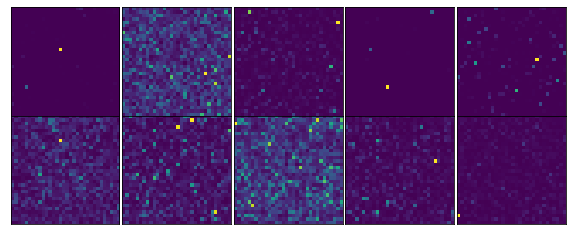

In [58]:
rng, key = jax.random.split(rng)
f_NLs = f_NL.sample(10, seed=key)["f_NL"].reshape((10, N, N))
fig, ax = plt.subplots(2, 5, figsize=(10, 4))
plt.subplots_adjust(wspace=0, hspace=0)
for i in range(2):
    for j in range(5):
        ax[i, j].imshow(f_NLs[j + i * 5])
        ax[i, j].set(xticks=[], yticks=[])

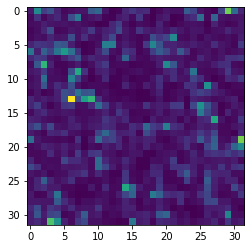

In [59]:
rng, key = jax.random.split(rng)
target = dict(
    f_NL=None,
    α=np.array(1.0),
    β=np.array(0.5))
target["f_NL"] = simulator(key, None, target["α"], target["β"])
plt.imshow(target["f_NL"].reshape((N, N)))

In [60]:
num_burnin_steps = 100
num_results = int(1e3)
num_chains = 250

In [61]:
rng, α_key, β_key = jax.random.split(rng, num=3)
init_state = np.stack(
    [tfd.Uniform(low=np.float32(0.), high=np.float32(2.)).sample(num_chains, seed=α_key),
     tfd.Uniform(low=np.float32(0.2), high=np.float32(0.8)).sample(num_chains, seed=β_key)], 
    1)

In [62]:
@jax.jit
def run_mcmc(rng):
    def fn(init_state):
        return tfp.mcmc.sample_chain(
            num_results=num_results,
            current_state=tuple(init_state),
            kernel = tfp.mcmc.RandomWalkMetropolis(
                target_log_prob_fn=lambda α, β: _f_NL(α, β).log_prob(target)),
            num_burnin_steps=num_burnin_steps,
            num_steps_between_results=1,
            trace_fn=lambda _, stats: stats.accepted_results.target_log_prob,
            seed=rng)
    return jax.vmap(fn)(init_state)

In [63]:
states = np.zeros((2, num_chains, 0))
stats = np.zeros((num_chains, 0))

In [64]:
rng, key = jax.random.split(rng)
_states, _stats = run_mcmc(key)
states = np.concatenate([states, np.stack(_states)], -1)
stats = np.concatenate([stats, _stats], -1)

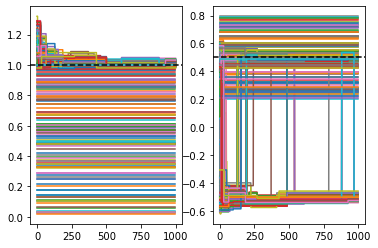

In [65]:
fig, ax = plt.subplots(1, 2)
ax[0].plot(states[0].T)
ax[0].axhline(target["α"], linestyle="dashed", color="black")
ax[1].plot(states[1].T)
ax[1].axhline(target["β"], linestyle="dashed", color="black")

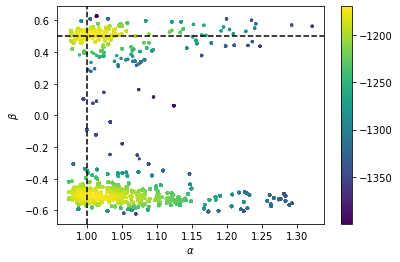

In [66]:
plt.scatter(states[0].flatten(), states[1].flatten(), c=stats.flatten(), s=5)
plt.axvline(target["α"], color="black", linestyle="dashed")
plt.axhline(target["β"], color="black", linestyle="dashed")
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$\beta$")
plt.colorbar()

In [29]:
states.shape

(2, 250, 1000)